In [2]:
import pandas as pd
import numpy as np

import lightgbm as lgb

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.utils import resample
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

import onnx
import onnxruntime as rt
import skl2onnx
from skl2onnx.common.data_types import FloatTensorType,Int64TensorType, StringTensorType
from skl2onnx import convert_sklearn

In [5]:
train = pd.read_csv("../datasets/train.csv")

### Conhecendo a base

In [5]:
#Datatypes
train.dtypes

id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

<Axes: xlabel='stroke'>

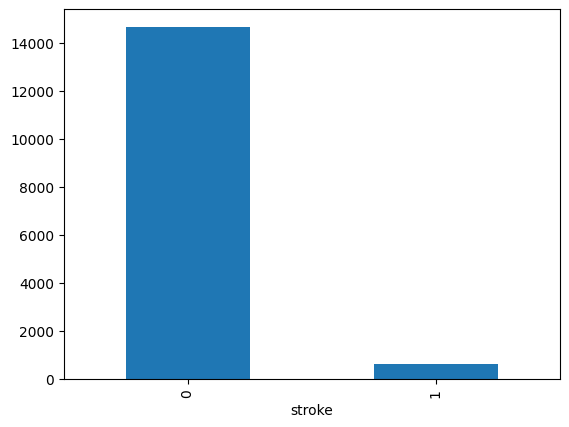

In [15]:
# Existe um grande desbalence entre a coluna target. Deve ser tratado
train.groupby(train['stroke']).count()['id'].plot.bar()

In [46]:
# Além disso, há muitas colunas categóricas que precisarão ser tratadas de alguma maneira.
train['smoking_status'].unique()

array(['never smoked', 'formerly smoked', 'Unknown', 'smokes'],
      dtype=object)

### Tratamentos

In [75]:
# Reamostrando a classe com mais amostras (downsampling)
not_stroke = train[train['stroke']==0]
stroke     = train[train['stroke']==1]
not_stroke_downsampled = resample(not_stroke,
                                replace = False, # sample without replacement
                                n_samples = len(stroke), # match minority n
                                random_state = 27)
print(not_stroke_downsampled.shape)

downsampled = pd.concat([not_stroke_downsampled, stroke])

print(downsampled.shape)

(632, 12)
(1264, 12)


In [56]:
X = downsampled.drop(['id', 'stroke'], axis=1)
X = X[['age', 'avg_glucose_level', 'bmi', 'smoking_status', 'Residence_type']]
y = downsampled['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42, stratify = y, shuffle=True)


### Treinamento

In [69]:
# Definindo as colunas categóricas e seus tratamentos
binary_features = ['Residence_type']
ordinal_features = ['smoking_status']


preprocessor = ColumnTransformer(
    transformers=[
        ('binary3', OrdinalEncoder(categories=[['Rural', 'Urban']]), ['Residence_type']),
        ('ordinal', OrdinalEncoder(categories=[['Unknown', 'never smoked', 'formerly smoked', 'smokes']]), ordinal_features)
    ],remainder='passthrough')

# Criando as pipelines para cada modelo, incluindo Random Forest e LightGBM
pipelines = {
    'Random Forest': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(random_state=15))
    ]),
    'LightGBM': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', lgb.LGBMClassifier(random_state=0))
    ]),
}

# Definindo a grid de parâmetros para Random Forest e LightGBM
param_grid = {
    'Random Forest': {
        'classifier__n_estimators': np.arange(100, 550, 50),
        'classifier__max_depth': [2, 4, 6],
        'classifier__criterion': ['gini', 'entropy']
    },
    'LightGBM': {
        'classifier__num_leaves': [31, 50, 70],
        'classifier__learning_rate': [0.01, 0.05, 0.1],
        'classifier__n_estimators': np.arange(100, 550, 50)
    }
}

# Aplicando GridSearchCV para Random Forest e LightGBM
grid_search_rf = GridSearchCV(pipelines['Random Forest'], param_grid['Random Forest'], cv=5, n_jobs=-1)
grid_search_lgb = GridSearchCV(pipelines['LightGBM'], param_grid['LightGBM'], cv=5, n_jobs=-1)

# Treinando as grid searches
fitted_grid_search_rf = grid_search_rf.fit(X_train, y_train)
fitted_grid_search_lgb = grid_search_lgb.fit(X_train, y_train)

# Melhor modelo encontrado para LightGBM
best_lgb = grid_search_lgb.best_estimator_
# Melhor modelo encontrado para RandomForest
best_rf = fitted_grid_search_rf.best_estimator_

[LightGBM] [Info] Number of positive: 506, number of negative: 505
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 580
[LightGBM] [Info] Number of data points in the train set: 1011, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500495 -> initscore=0.001978
[LightGBM] [Info] Start training from score 0.001978


In [68]:
# Prevendo o conjunto de teste usando LightGBM
y_pred_lgb = best_lgb.predict(X_test)

# Avaliação do modelo LightGBM
accuracy_lgb = accuracy_score(y_test, y_pred_lgb)
classification_rep_lgb = classification_report(y_test, y_pred_lgb)

# Exibindo os resultados
print(f"Acurácia do LightGBM no conjunto de teste: {accuracy_lgb:.4f}")
print("\nRelatório de classificação do LightGBM:\n", classification_rep_lgb)

Acurácia do LightGBM no conjunto de teste: 0.7905

Relatório de classificação do LightGBM:
               precision    recall  f1-score   support

           0       0.81      0.76      0.78       127
           1       0.77      0.83      0.80       126

    accuracy                           0.79       253
   macro avg       0.79      0.79      0.79       253
weighted avg       0.79      0.79      0.79       253



In [73]:
# Prevendo o conjunto de teste usando LightGBM
y_pred_rf = best_rf.predict(X_test)

# Avaliação do modelo LightGBM
accuracy_rf = accuracy_score(y_test, y_pred_rf)
classification_rep_rf = classification_report(y_test, y_pred_lgb)

# Exibindo os resultados
print(f"Acurácia do LightGBM no conjunto de teste: {accuracy_rf:.4f}")
print("\nRelatório de classificação do LightGBM:\n", classification_rep_rf)

Acurácia do LightGBM no conjunto de teste: 0.8024

Relatório de classificação do LightGBM:
               precision    recall  f1-score   support

           0       0.81      0.76      0.78       127
           1       0.77      0.83      0.80       126

    accuracy                           0.79       253
   macro avg       0.79      0.79      0.79       253
weighted avg       0.79      0.79      0.79       253



### Gerando Artefato

In [81]:
def convert_dataframe_schema(df, drop=None):
    inputs = []
    for k, v in zip(df.columns, df.dtypes):
        if drop is not None and k in drop:
            continue
        if v == "int64":
            t = Int64TensorType([None, 1])
        elif v == "float64":
            t = FloatTensorType([None, 1])
        else:
            t = StringTensorType([None, 1])
        inputs.append((k, t))
    return inputs


initial_inputs = convert_dataframe_schema(X_train)

try:
    model_onnx = convert_sklearn(
        best_rf, "pipeline_random_forest", initial_inputs, target_opset=12
    )
except Exception as e:
    print(e)


with open("../atifacts/stroke_rf.onnx", "wb") as f:
    f.write(model_onnx.SerializeToString())